In [1]:
from utils import *

In [2]:
z_size = 32
batch_size = 100
mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def encoder(inputs):
    '''
        input :
            inputs [None, 784]
        return :
            mu, sigma
    '''
    Encoder = {}
    with tf.variable_scope("Encoder"):
        Encoder['inputs_reshape'] = tf.reshape(inputs, [-1,28,28,1])
        with tf.variable_scope('conv1'):
            Encoder['conv1'] = convolution(Encoder['inputs_reshape'], 5, 5, 1, 8)
            Encoder['pool1'] = tf.nn.max_pool(Encoder['conv1'], ksize=[1,2,2,1] ,strides=[1,2,2,1],padding = 'SAME')
        with tf.variable_scope('conv2'):
            Encoder['conv2'] = convolution(Encoder['pool1'], 5, 5, 8, 16)
            Encoder['pool2'] = tf.nn.max_pool(Encoder['conv2'], ksize=[1,2,2,1] ,strides=[1,2,2,1],padding = 'SAME')
        with tf.variable_scope('conv3'):
            Encoder['conv3'] = convolution(Encoder['pool2'], 3, 3, 16, 16)
        Encoder['conv3_reshape'] = tf.reshape(Encoder['conv3'], [batch_size, 2*2*16])
        with tf.variable_scope('mu'):
            Encoder['mu'] = fully_connected(Encoder['conv3_reshape'], 2*2*16, z_size)
        with tf.variable_scope('sigma'):
            Encoder['sigma'] = tf.nn.elu(fully_connected(Encoder['conv3_reshape'], 2*2*16, z_size)/2)
        return Encoder['mu'], Encoder['sigma']

def sampling_z(z_mu, z_sigma):
    return z_mu + z_sigma*np.random.randn(batch_size, z_size)

def decoder(z_samples, reuse=False):
    with tf.variable_scope("Decoder") as scope:
        if reuse: 
            scope.reuse_variables()
        Decoder = {}
        with tf.variable_scope("fc1"):
            Decoder['fc1'] = fully_connected(z_samples, z_size, 1024)
        with tf.variable_scope("fc2"):
            Decoder['fc2'] = fully_connected(Decoder['fc1'], 1024, 7*7*128)
        Decoder['reshape1'] = tf.reshape(Decoder['fc2'], [batch_size, 7, 7, 128])
        with tf.variable_scope("deconv1"):
            Decoder['deconv1'] = tf.nn.elu(deconvolution(Decoder['reshape1'], 
                                                         [5, 5, 64, 128],
                                                         [1, 2, 2, 1],
                                                         [batch_size, 14, 14, 64]))
        with tf.variable_scope("deconv2"):
            Decoder['deconv2'] = deconvolution(Decoder['deconv1'],
                                                         [5, 5, 1, 64],
                                                         [1, 2, 2, 1],
                                                         [batch_size, 28, 28, 1])     
        
        Decoder['logits'] = tf.reshape(Decoder['deconv2'], [batch_size, 28*28])
        Decoder['probs'] = tf.sigmoid(Decoder['logits'])
        return Decoder['logits'], Decoder['probs']

In [4]:
x = tf.placeholder(tf.float32, [batch_size, 784])
z_mu, z_sigma = encoder(x)
z_samples = sampling_z(z_mu, z_sigma)
logits, probs = decoder(z_samples)

In [5]:
with tf.variable_scope('loss'):
    reconstruction_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels= x))
    KL_divergence_loss = 1/2 * tf.reduce_mean(z_sigma**2 + z_mu**2 - 1 - tf.log(z_sigma**2))
    loss = tf.reduce_mean(reconstruction_loss + KL_divergence_loss)

In [6]:
learning_rate = 0.001
trainer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [7]:
num_batch = int(mnist.train.num_examples/batch_size)
epoch = 20

In [8]:
#train_X, train_ys = mnist.train.next_batch(batch_size)
#print("z_mu : {}".format(sess.run(z_mu, feed_dict={ x :train_X})))
#print("z_sigma : {}".format(sess.run(z_sigma, feed_dict={ x :train_X})))
#print("z_samples : {}".format(sess.run(z_samples, feed_dict={ x :train_X})))
#print("logits : {}".format(sess.run(logits, feed_dict={ x :train_X})))
#print("probs : {}".format(sess.run(probs, feed_dict={ x :train_X})))
#print("reconst loss : {}".format(sess.run(reconstruction_loss, feed_dict={ x :train_X})))
#print("KL loss : {}".format(sess.run(KL_divergence_loss, feed_dict={ x :train_X})))

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for _ in range(epoch):
    avg_cost = 0
    for nb in range(num_batch):
        train_X, train_ys = mnist.train.next_batch(batch_size)
        loss_get, train_ = sess.run([loss, trainer], feed_dict={ x :train_X})
        avg_cost += loss_get

    avg_cost/= num_batch
    print("Epoch({}/{}) : cost= {}".format(_+1, epoch, avg_cost))

Epoch(1/20) : cost= 666.8015634434873
Epoch(2/20) : cost= 2.2293057398362595
Epoch(3/20) : cost= 0.8297585384412245


KeyboardInterrupt: 

In [9]:
generated_z = np.random.normal(size=(batch_size, z_size)).astype(np.float32)
_, probs = decoder(generated_z, reuse=True)
images = np.reshape(sess.run(probs), [100, 28, 28,1])

In [10]:
def square_plot(data):
    if type(data) == list:
        data = np.concatenate(data)
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))

    padding = (((0, n ** 2 - data.shape[0]) ,
                (0, 1), (0, 1))  # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data , padding, mode='constant' , constant_values=1)  # pad with ones (white)

    # tilethe filters into an image
    data = data.reshape((n , n) + data.shape[1:]).transpose((0 , 2 , 1 , 3) + tuple(range(4 , data.ndim + 1)))

    data = data.reshape((n * data.shape[1] , n * data.shape[3]) + data.shape[4:])

    fig = plt.figure(figsize=(17, 17))
    plt.imshow(data[:,:,0], cmap='gray')
    plt.axis('off')
    plt.close()
    return fig

In [11]:
fig = square_plot(images)

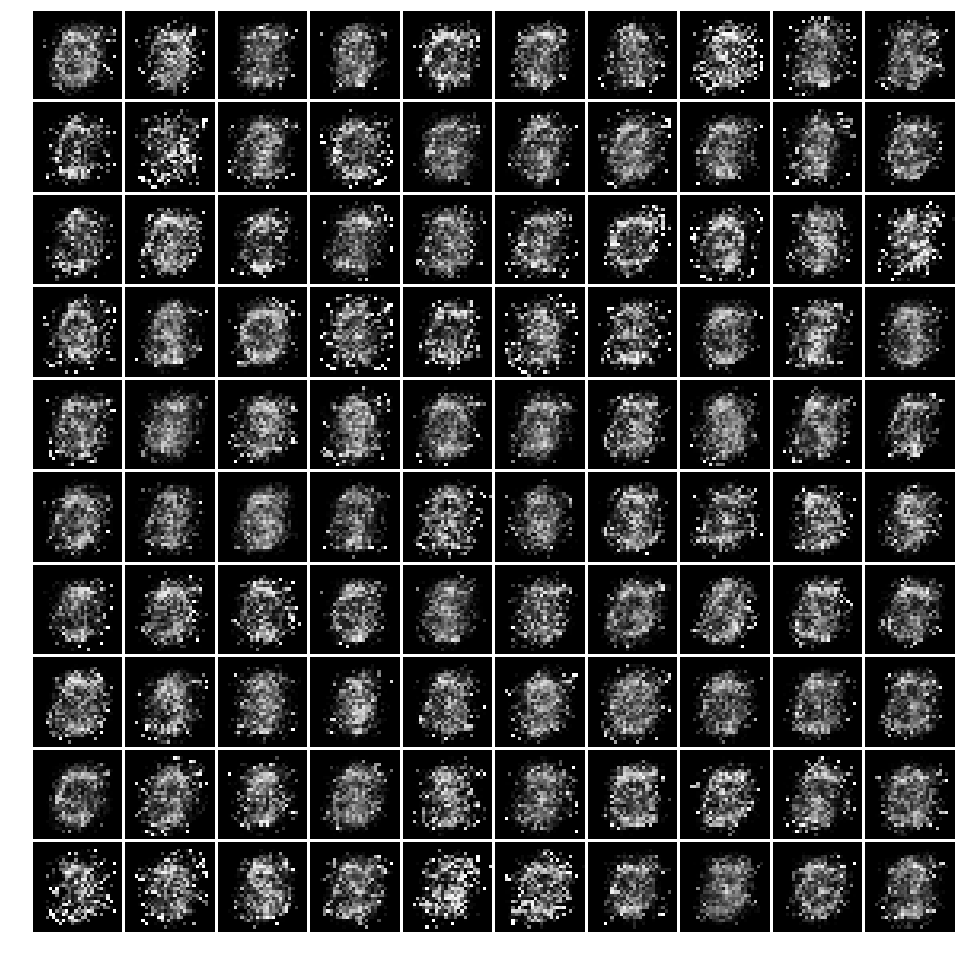

In [12]:
fig